# Artificial Neural Network and Deep Learning - Challenge 1

## Hyperparameters

In [76]:
SEED = 100

# Training
EPOCHS = 500                    # Maximum epochs (increase to improve performance)
PATIENCE = 50                   # Early stopping patience (increase to improve performance)
VERBOSE = 1                     # Print frequency

# Optimisation
LEARNING_RATE = 0.001          # Learning rate
BATCH_SIZE = 32                 # Batch size
WINDOW_SIZE = 100               # Input window size
STRIDE = 25                     # Input stride

# Architecture
HIDDEN_LAYERS = 2               # Hidden layers
HIDDEN_SIZE = 256               # Neurons per layer
RNN_TYPE = 'LSTM'               # Type of RNN architecture ['RNN', 'LSTM', 'GRU']
BIDIRECTIONAL = True            # Bidirectional RNN

# Regularisation
NOISE_STD_DEV = 0.1             # Data Augmentation: Added noise on training dataset
DROPOUT_RATE = 0.2              # Dropout probability
L1_LAMBDA = 0.0                 # L1 penalty
L2_LAMBDA = 0.001               # L2 penalty

# Prediction
PREDICT_FLAG = False                   # Enable test set prediction

#-------------------# 

# Cross-validation [NO AFFECT, this notebook removed k-folding cross validation]
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 5          # Number of users for validation split
N_TEST_USERS = 5         # Number of users for test split



## Libraries and dataset import

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import random
import torch
import os
from itertools import product
from itertools import chain

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import torch.nn as nn
from datetime import datetime 


# Set all seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

df_train = pd.read_csv('pirate_pain_train.csv')
df_labels = pd.read_csv('pirate_pain_train_labels.csv')



PyTorch version: 2.9.0+cu128
Device: cuda


In [78]:
# %%
def build_fixed_sequences(df_features, df_labels, feature_cols, joint_cols, label_map, 
                          window=200, stride=50):
    """
    Builds fixed-size, overlapping sequences from the dataset.
    This function normalizes each sample individually before windowing.
    """
    dataset = []
    labels = []
    n_features = len(feature_cols)

    print(f"Building fixed sequences with window={window}, stride={stride}...")

    # Iterate over unique sample indices
    for sid in df_features['sample_index'].unique():
        
        # 1. Get features
        temp_features = df_features[df_features['sample_index'] == sid].sort_values('time')[feature_cols].values
        
        # 2. Get label
        label_str = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
        label_numeric = label_map[label_str]

        # 3. Normalize
        temp_features_tensor = torch.FloatTensor(temp_features)
        joint_data = temp_features_tensor[:, :len(joint_cols)]
        joint_min = joint_data.min(dim=0)[0]
        joint_max = joint_data.max(dim=0)[0]
        joint_range = joint_max - joint_min
        joint_range[joint_range == 0] = 1
        normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
        temp_features_tensor[:, :len(joint_cols)] = normalized_joints
        temp_features_normalized = temp_features_tensor.numpy()

        # 4. Apply padding (from your original logic)
        padding_len = window - len(temp_features_normalized) % window
        
        padding = np.zeros((padding_len, n_features), dtype='float32')
        temp_features_padded = np.concatenate((temp_features_normalized, padding))

        # 5. Apply windowing logic
        idx = 0
        while idx + window <= len(temp_features_padded):
            dataset.append(temp_features_padded[idx:idx + window])
            labels.append(label_numeric)
            idx += stride

    dataset = np.array(dataset, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    return dataset, labels

## Preprocessing

### Windows Creation

In [79]:

# --- 1. Define feature columns and label map ---
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
feature_cols = joint_cols + pain_cols # Using all features
input_size = len(feature_cols)

# Create label map
unique_labels = sorted(df_labels['label'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(label_map)

print(f"Feature columns: {input_size}")
print(f"Label map: {label_map}")

# --- 2. Split by Sample Index (Leakage Fix) ---
unique_sids = df_labels['sample_index'].unique()

train_sids, val_sids = train_test_split(
    unique_sids,
    test_size=0.2,
    random_state=SEED,
    stratify=df_labels['label'] # Stratify on the original labels (We must split by SAMPLE INDEX to prevent data leakage.)
)

# Create 'split' mappings
split_map = {sid: 'train' for sid in train_sids}
split_map.update({sid: 'val' for sid in val_sids})

# Filter the DataFrames *before* building sequences
df_train_split = df_train[df_train['sample_index'].isin(train_sids)]
df_labels_train_split = df_labels[df_labels['sample_index'].isin(train_sids)]

df_val_split = df_train[df_train['sample_index'].isin(val_sids)]
df_labels_val_split = df_labels[df_labels['sample_index'].isin(val_sids)]

# --- 3. Build all sequences ---
X_train, y_train = build_fixed_sequences(
    df_train_split, df_labels_train_split, 
    feature_cols, joint_cols, label_map,
    window=WINDOW_SIZE,
    stride=STRIDE
)

X_val, y_val = build_fixed_sequences(
    df_val_split, df_labels_val_split, 
    feature_cols, joint_cols, label_map,
    window=WINDOW_SIZE,
    stride=STRIDE # No overlap for validation is fine, but overlap is also fine
)

print(f"\nTotal windows created (Train): {len(X_train)}")
print(f"Total windows created (Val):   {len(X_val)}")
print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes  : X={X_val.shape}, y={y_val.shape}")

# --- 4. Create new, flexible Dataset ---
class PainDataset(Dataset):
    def __init__(self, X, y, is_train=False, n_joint_cols=0, noise_level=0.01):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
        self.is_train = is_train
        self.n_joint_cols = n_joint_cols
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_sample = self.X[idx].clone() 
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_sample[:, :self.n_joint_cols] = x_sample[:, :self.n_joint_cols] + noise.to(x_sample.device)
            
        return x_sample, y_sample

# --- 5. Create new DataLoaders ---
n_joint_cols = len(joint_cols) 

train_dataset = PainDataset(
    X_train, y_train, 
    is_train=True, 
    n_joint_cols=n_joint_cols, 
    noise_level=NOISE_STD_DEV
)
val_dataset = PainDataset(
    X_val, y_val, 
    is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



Feature columns: 35
Label map: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
Building fixed sequences with window=100, stride=25...
Building fixed sequences with window=100, stride=25...

Total windows created (Train): 2640
Total windows created (Val):   665

Train shapes: X=(2640, 100, 35), y=(2640,)
Val shapes  : X=(665, 100, 35), y=(665,)
Building fixed sequences with window=100, stride=25...

Total windows created (Train): 2640
Total windows created (Val):   665

Train shapes: X=(2640, 100, 35), y=(2640,)
Val shapes  : X=(665, 100, 35), y=(665,)


### Cross Entropy weighting

label
no_pain      0.773071
low_pain     0.142209
high_pain    0.084720
Name: proportion, dtype: float64


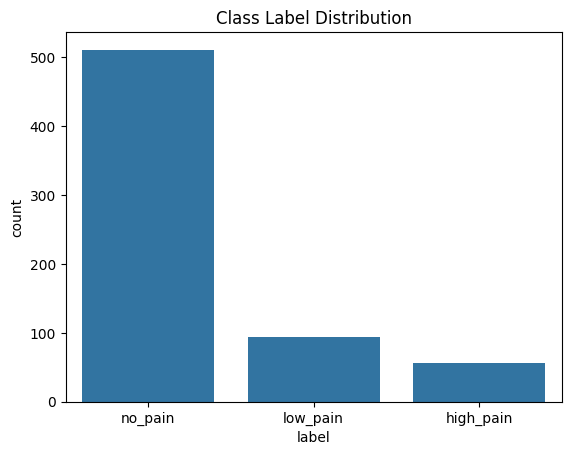

Label proportions:
 label
high_pain    0.084720
low_pain     0.142209
no_pain      0.773071
Name: proportion, dtype: float64

Calculated Weights:
 label
high_pain    0.586395
low_pain     0.349342
no_pain      0.064263
Name: proportion, dtype: float64


In [80]:
# CHECK CLASS DISTRIBUTION
print(df_labels['label'].value_counts(normalize=True))

sns.countplot(x='label', data=df_labels)
plt.title('Class Label Distribution')
plt.show()

# --- CLASS WEIGHTING (FOR IMBALANCE) ---
# We must load df_labels here to calculate weights
df_labels_for_weights = pd.read_csv('pirate_pain_train_labels.csv')
label_proportions = df_labels_for_weights['label'].value_counts(normalize=True).sort_index()
print("Label proportions:\n", label_proportions)

# Calculate weights (1 / proportion)
weights = 1.0 / label_proportions
weights = weights / weights.sum()
print("\nCalculated Weights:\n", weights)

weights_tensor = torch.tensor(weights.values, dtype=torch.float32)

# Set Criterion with weights
CRITERION = nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Neural Network Model

In [81]:
class RecurrentClassifier(nn.Module):

    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.batch_norm = nn.BatchNorm1d(input_size)


        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits



In [82]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):

    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)


            # Check loss for NaN
            if torch.isnan(loss):
                print(f"NaN loss at batch {batch_idx}")
                print(f"Input range: [{inputs.min():.4f}, {inputs.max():.4f}]")
                print(f"Logits range: [{logits.min():.4f}, {logits.max():.4f}]")
                continue

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [83]:
def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [84]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)


        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [85]:
def recurrent_summary(model, input_size):


    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---
    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

### K-Cross Validation [Not used in this notebook]

In [86]:


def k_fold_cross_validation(df_train, df_labels, epochs, criterion, device,
                            k, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            rnn_type, bidirectional, l1_lambda=0, l2_lambda=0, patience=0, 
                            evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold cross-validation for pain classification using time series data.
    """
    # Initialize containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get feature columns
    joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
    pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
    feature_cols = joint_cols 

    # Create global label mapping to ensure consistency across folds
    label_map = {label: i for i, label in enumerate(sorted(df_labels['label'].unique()))}
    num_classes = len(label_map)

    # Initialize model architecture
    model = RecurrentClassifier(
        input_size=len(feature_cols),
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = model.state_dict().copy()

    # Get unique sample indices for splitting
    unique_samples = df_train['sample_index'].unique()
    np.random.seed(seed)
    unique_samples_shuffled = np.random.permutation(unique_samples)

    # Create k folds
    fold_size = len(unique_samples) // k
    folds = [unique_samples_shuffled[i:i + fold_size] for i in range(0, len(unique_samples_shuffled), fold_size)]

    # Iterate through K folds
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\nFold {fold_idx+1}/{k}")

        # Use current fold as validation set, rest as training set
        val_samples = folds[fold_idx]
        train_samples = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))

        # Split data into train and validation
        train_data = []
        train_labels = []
        val_data = []
        val_labels = []

        # Create sequences for training set
        for sid in train_samples:
            seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
            train_data.append(torch.FloatTensor(seq))
            label = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
            train_labels.append(label_map[label])

        # Create sequences for validation set
        for sid in val_samples:
            seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
            val_data.append(torch.FloatTensor(seq))
            label = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
            val_labels.append(label_map[label])

        # Normalize sequences (only joint data)
        for sequences in [train_data, val_data]:
            for i in range(len(sequences)):
                joint_data = sequences[i][:, :len(joint_cols)]
                joint_min = joint_data.min(dim=0)[0]
                joint_max = joint_data.max(dim=0)[0]
                joint_range = joint_max - joint_min
                joint_range[joint_range == 0] = 1
                normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
                sequences[i][:, :len(joint_cols)] = normalized_joints

        # Create datasets and dataloaders
        train_dataset = PainDataset(train_data, torch.LongTensor(train_labels))
        val_dataset = PainDataset(val_data, torch.LongTensor(val_labels))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                              shuffle=False, collate_fn=collate_fn)

        if verbose > 0:
            print(f"  Training sequences: {len(train_data)}")
            print(f"  Validation sequences: {len(val_data)}")

        # Reset model to initial weights
        model.load_state_dict(initial_state)

        # Define optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current fold
        _, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=fold_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/fold_{fold_idx}"
        )

        # Store results for this fold
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        best_scores[f"fold_{fold_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("fold_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("fold_")])

    if verbose > 0:
        print(f"\nCross-validation score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

## Model Creation and Training

In [ ]:
rnn_model = RecurrentClassifier(
    input_size=input_size, 
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    ).to(device)

recurrent_summary(rnn_model, input_size=(WINDOW_SIZE, input_size))

optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"model_{timestamp}"
print(f"Starting experiment: {experiment_name}")

# Train model
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=CRITERION,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=VERBOSE, 
    experiment_name=experiment_name,
    patience=PATIENCE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=0.0, # L2 handled by optimizer 
    evaluation_metric="val_f1",
    )

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 100, 512], [4, -1, 256]] 2,177,024      
classifier (Linear)       [-1, 3]                      1,539          
Total params: 2,178,563
Trainable params: 2,178,563
Non-trainable params: 0
-------------------------------------------------------------------------------
Starting experiment: model_20251108_125515
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0039, F1 Score=0.6474 | Val: Loss=0.8398, F1 Score=0.7812
Epoch   1/500 | Train: Loss=1.0039, F1 Score=0.6474 | Val: Loss=0.8398, F1 Score=0.7812
Epoch   2/500 | Train: Loss=0.8708, F1 Score=0.7707 | Val: Loss=0.7750, F1 Score=0.8137
Epoch   2/500 | Train: Loss=0.8708, F1 Score=0.7707 | Val: Loss=0.7750, F1 Score=0.8137
Epoch   3/500 | Train: Loss=0.8203, F1 Score=0.7977 | Val: Loss=0.7745, F1 Score=0.7987
Epoch   3/500 | Train: Loss=0.8203, F1 S

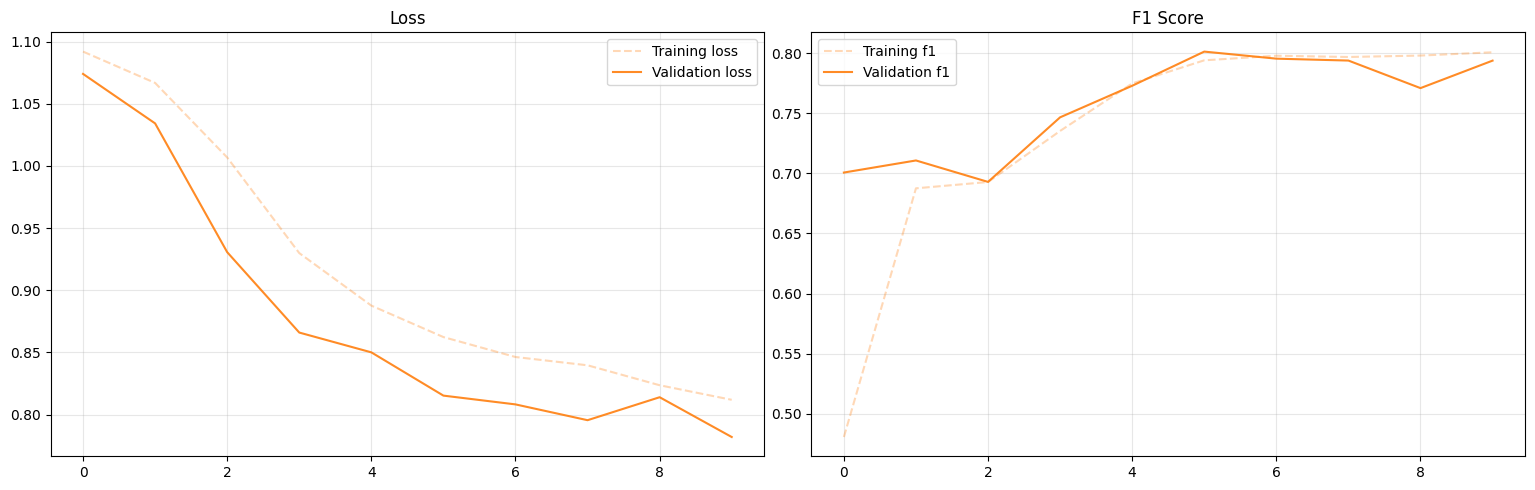

In [ ]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

### Logging

Accuracy over the validation set: 0.8030
Precision over the validation set: 0.8037
Recall over the validation set: 0.8030
F1 score over the validation set: 0.8014


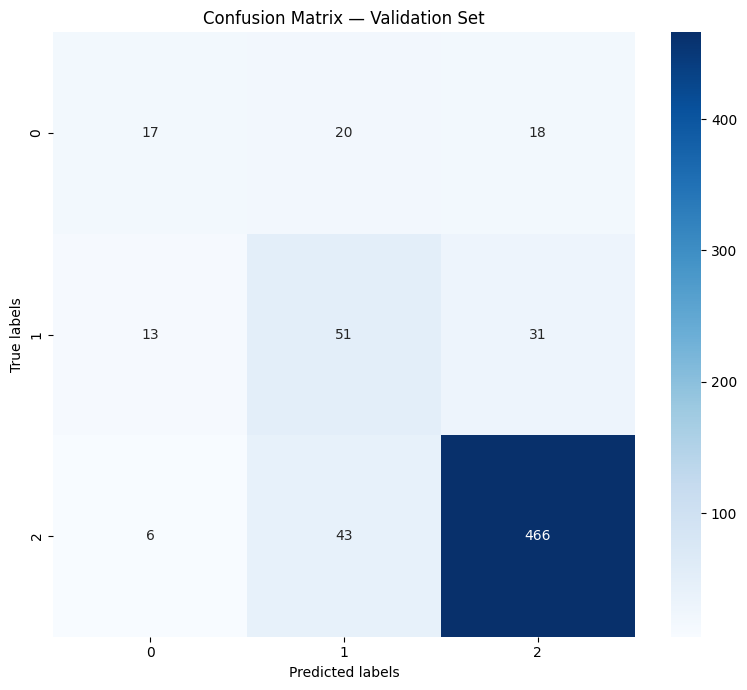

In [ ]:

# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Parameters and Results Logging

In [ ]:
print("Training complete. Logging results...")

# 1. Find the best scores from the history
if training_history['val_f1']: 
    best_val_f1 = max(training_history['val_f1'])
    best_epoch_index = np.argmax(training_history['val_f1'])
    best_val_loss = training_history['val_loss'][best_epoch_index]
    best_epoch = best_epoch_index + 1 
else:
    best_val_f1 = 0.0
    best_val_loss = 0.0
    best_epoch = 0

try:
    with open("model_history.txt", "a") as f:
        # Get current time for the log entry
        log_time = timestamp
        
        f.write(f"--- Log Entry: {log_time} ---\n")
        f.write(f"Experiment Name: {experiment_name}\n")
        f.write("\n")
        f.write("Hyperparameters:\n")
        f.write(f"  - EPOCHS: {EPOCHS}\n")
        f.write(f"  - PATIENCE: {PATIENCE}\n")
        f.write(f"  - LEARNING_RATE: {LEARNING_RATE}\n")
        f.write(f"  - BATCH_SIZE: {BATCH_SIZE}\n")
        f.write(f"  - WINDOW_SIZE: {WINDOW_SIZE}\n")
        f.write(f"  - STRIDE: {STRIDE}\n")
        f.write(f"  - HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
        f.write(f"  - HIDDEN_SIZE: {HIDDEN_SIZE}\n")
        f.write(f"  - RNN_TYPE: {RNN_TYPE}\n")
        f.write(f"  - BIDIRECTIONAL: {BIDIRECTIONAL}\n")
        f.write(f"  - DROPOUT_RATE: {DROPOUT_RATE}\n")
        f.write(f"  - L2_LAMBDA (Weight Decay): {L2_LAMBDA}\n")
        f.write(f"  - L1_LAMBDA: {L1_LAMBDA}\n")
        f.write(f"  - NOISE_STD_DEV: {NOISE_STD_DEV}\n")
        f.write("\n")
        f.write("Best Model Results (from Early Stopping):\n")
        f.write(f"  - Best Validation F1 Score: {best_val_f1:.4f}\n")
        f.write(f"  - Best Validation Loss: {best_val_loss:.4f}\n")
        f.write(f"  - Found at Epoch: {best_epoch}\n")
        f.write("--------------------------------------\n\n")
    
    print("Successfully wrote training results to model_history.txt")

except Exception as e:
    print(f"Error writing to model_history.txt: {e}")


Training complete. Logging results...
Successfully wrote training results to model_history.txt


## Prediction on Test

In [ ]:
if PREDICT_FLAG:
    class TestWindowDataset(Dataset):
        def __init__(self, data):
            self.data = data
        def __getitem__(self, index):
            return self.data[index]
        def __len__(self):
            return self.data.shape[0]

    print("\n--- Starting Test Set Prediction ---")
    df_test = pd.read_csv('pirate_pain_test.csv')

    # Convert float64 to float32
    float_cols = df_test.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df_test[col] = df_test[col].astype(np.float32)

    # Use the INVERSE label map to convert numeric predictions back to strings
    inv_label_map = {v: k for k, v in label_map.items()}

    # --- Window the Test Data ---
    test_windows = []
    test_window_indices = [] # This will store the sample_index for each window

    for sid in df_test['sample_index'].unique():
        seq_df = df_test[df_test['sample_index'] == sid]
        
        if len(seq_df) == 0:
            print(f"Warning: No features for test sample {sid}. Skipping.")
            continue
            
        # Use the same features as training
        seq = seq_df.sort_values('time')[feature_cols].values
        
        # Normalize (per-sample)
        seq_tensor = torch.FloatTensor(seq)
        joint_data = seq_tensor[:, :len(joint_cols)]
        joint_min = joint_data.min(dim=0)[0]
        joint_max = joint_data.max(dim=0)[0]
        joint_range = joint_max - joint_min
        joint_range[joint_range == 0] = 1
        normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
        seq_tensor[:, :len(joint_cols)] = normalized_joints
        seq_normalized = seq_tensor.numpy()

        # Pad
        padding_len = WINDOW_SIZE - len(seq_normalized) % WINDOW_SIZE
        if padding_len < WINDOW_SIZE:
            padding = np.zeros((padding_len, input_size), dtype='float32')
            seq_padded = np.concatenate((seq_normalized, padding))
        else:
            seq_padded = seq_normalized
            
        # Window
        idx = 0
        while idx + WINDOW_SIZE <= len(seq_padded):
            test_windows.append(seq_padded[idx:idx + WINDOW_SIZE])
            test_window_indices.append(sid)
            idx += STRIDE

    X_test_windows = torch.tensor(np.array(test_windows), dtype=torch.float32)
    print(f"Created {len(X_test_windows)} test windows from {df_test['sample_index'].nunique()} samples.")

    # --- Create Test DataLoader (no labels, no collate_fn) ---
    test_dataset = TestWindowDataset(X_test_windows)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Get predictions for ALL windows ---
    rnn_model.eval() # Use the 'rnn_model' that was just trained
    window_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            outputs = rnn_model(batch)
            pred = outputs.argmax(dim=1).cpu().numpy()
            window_predictions.extend(pred)

    # --- Combine window predictions into sample predictions (Majority Vote) ---
    df_window_preds = pd.DataFrame({
        'sample_index': test_window_indices,
        'prediction': window_predictions
    })

    # Use .apply() to find the mode (most common prediction) for each group
    def get_majority_vote(x):
        # .mode() can return multiple if there's a tie, .iloc[0] picks the first one
        return x.mode().iloc[0] 

    final_predictions = df_window_preds.groupby('sample_index')['prediction'].apply(get_majority_vote)

    # Format for submission
    submission_df = final_predictions.reset_index()
    submission_df['label'] = submission_df['prediction'].map(inv_label_map)
    submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{int(x):03d}")

    # Ensure all test samples are present, even if no features were found
    all_test_sids = pd.DataFrame({'sample_index': [f"{int(idx):03d}" for idx in df_test['sample_index'].unique()]})
    submission_df = all_test_sids.merge(submission_df, on='sample_index', how='left')

    # Fill any missing predictions (e.g., from samples with no features) with the majority class
    # Get majority class from the *training* labels
    majority_class_numeric = pd.Series(y_train).mode().iloc[0]
    majority_class_label = inv_label_map[majority_class_numeric]
    submission_df['label'] = submission_df['label'].fillna(majority_class_label)
    print(f"Filling {submission_df['label'].isna().sum()} missing predictions with majority class '{majority_class_label}'")


    # Save to CSV
    NAME_CSV_PREDICTION = f"submission_{timestamp}.csv"
    submission_df[['sample_index', 'label']].to_csv(NAME_CSV_PREDICTION, index=False)
    print(f"Predictions saved to {NAME_CSV_PREDICTION}")
    print(submission_df.head())
else:
    print("\n--- Prediction flag is set to False. Exiting without test predictions. ---")




--- Prediction flag is set to False. Exiting without test predictions. ---
